In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_slim

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_684_990.csv"#fitlered=513-1050 #"mango_684_990.csv" #"mango_729_975.csv" 
n_components = 59
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02") #1.01/")
model_path = Path("D:/workspace/lazydeep/experiments/2.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\1.02\mango_684_990


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]

#data = ut.sample_data(data,random_state)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


In [4]:
model_num = "random_48"
k = 500
model_names = [model_num]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}


predictor = f"lwr_k={k}"
lazy_predictors = {predictor:LocalWeightedRegression(k,kernal=False)}
#{predictor:LocalWeightedRegression(k,kernal=True)}


#for each model, load state
print(f"Loaded {len(deep_models)} models")


Loaded 1 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = StandardScaler() # PLSRegression(n_components=n_components)
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/"models"/name/f"_fold_{fold}")
load_fun_build = lambda name,model : model.load_state(model_dir/"models"/name/f"_final")
load_fun_pp_build = None #lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

In [7]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
#deep_scores, deep_preds, _ , _, _ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

print(deep_scores_final)
print(f"SD AE: {np.std(np.abs(deep_preds_final['y']-deep_preds_final[model_num]))}")

Building final model - Train 7793 - Test 1949'
Tested (test) on 1949 instances with mean losses of: random_48:1733.4335'
Testing (test) took 0:00:00.388001'
{'MSE': {'random_48': 1733.433518483103}, 'R2': {'random_48': -283.8649297788297}}
SD AE: 25.75601090792367


In [8]:
lwr_scheme = DeepLWRScheme_1_to_n(lwr_models =lazy_predictors,n_neighbours=500,loss_fun_sk = mean_squared_error)
lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(deep_models,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

print(lwr_scores_final)
print(f"SD AE: {np.std(np.abs(lwr_preds_final['y']-lwr_preds_final[predictor]))}")

Building final model - Train 7793 - Test 1949'


MemoryError: Unable to allocate 463. MiB for an array with shape (7793, 7793) and data type int64

In [9]:
results_path = Path('D:/workspace/lazydeep/experiments/1.02/mango_684_990/random_59')
cv_preds = pd.read_csv(results_path/"predictions.csv")
test_preds = pd.read_csv(results_path/"predictions_test.csv")

In [32]:
test_lr = test_preds['lr']
test_deep = test_preds['deep']
test_lwr = test_preds['lwr_k=200']
test_lwr1 = test_preds['lwr_k=100']
test_lwr5 = test_preds['lwr_k=500']
test_y = test_preds['y']

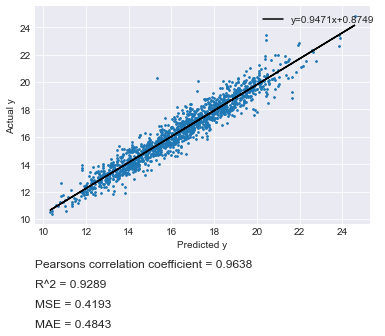

In [14]:
from plot import scatter_plot

fig,ax = scatter_plot(test_preds,'y','lr')
plt.savefig(results_path / f"prod_lr.png",bbox_inches='tight')

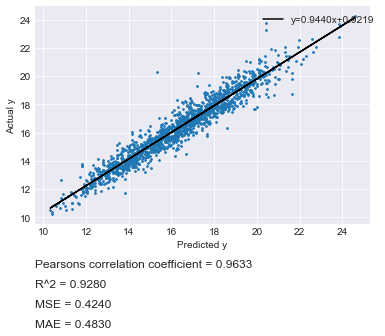

In [15]:
fig,ax = scatter_plot(test_preds,'y','lwr_k=200')
plt.savefig(results_path / f"prod_lwr.png",bbox_inches='tight')

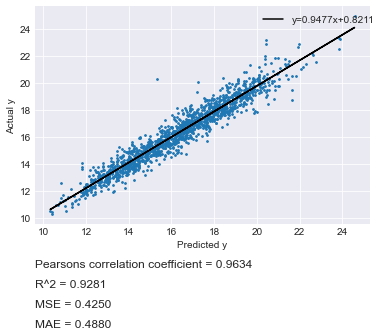

In [16]:
fig,ax = scatter_plot(test_preds,'y','deep')
plt.savefig(results_path / f"prod_deep.png",bbox_inches='tight')

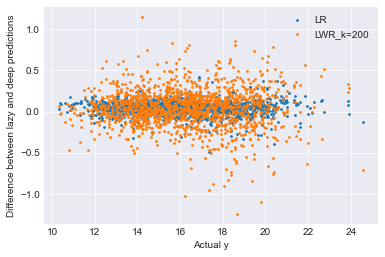

In [36]:
fig,ax = plt.subplots()

ax.scatter(test_y,(test_lr-test_deep),label="LR",s=3)
ax.scatter(test_y,(test_lwr-test_deep),label="LWR_k=200",s=3)
#ax.scatter(test_y,(test_lwr1-test_deep),label="LWR_100",s=3)
#ax.scatter(test_y,(test_lwr5-test_deep),label="LWR_500",s=3)

ax.legend(bbox_to_anchor=(1.,1),loc='upper right')
ax.set_ylabel("Difference between lazy and deep predictions")
ax.set_xlabel("Actual y")
plt.savefig(results_path / f"prod_diff.png",bbox_inches='tight')